In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
%matplotlib inline

# machine learning
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

#preprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Metrics Libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



In [2]:
dfRaw = pd.read_csv('./Data/Input.csv', delimiter = ',', nrows = 100000)


# Encode categorical columns
df = dfRaw.copy()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Convert everything to float
df = df.astype(float)


dfRaw.head(5)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
#Checking for balance in target
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=df['isFraud'].value_counts())])
fig.show()

In [12]:
#preprocessing

#drop 'isFraud' from X
X = df.drop('isFraud', axis=1)
y = df['isFraud']

#split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)

In [13]:
def Standard_Scaler(train_df, test_df, col_names):
    scaler = StandardScaler()
    
    # Fit on training data and transform both sets
    train_df[col_names] = scaler.fit_transform(train_df[col_names])
    test_df[col_names] = scaler.transform(test_df[col_names])
    
    return train_df, test_df

col_names = ['type', 'amount']
X_train, X_test = Standard_Scaler(X_train, X_test, col_names)

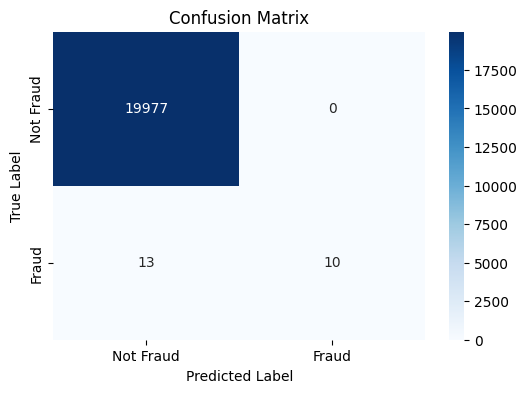

Random Forest Classifier Accuracy: [0.9991875 0.9991875 0.9990625 0.9991875 0.9993125]
Cross Validation Recall scores are: [0.27777778 0.27777778 0.21052632 0.31578947 0.42105263]
Average Cross Validation Recall score: 0.30058479532163745
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     19977
       Fraud       1.00      0.43      0.61        23

    accuracy                           1.00     20000
   macro avg       1.00      0.72      0.80     20000
weighted avg       1.00      1.00      1.00     20000



In [9]:
#training without sampling

kf = StratifiedKFold(n_splits=5, shuffle=False)

rf = RandomForestClassifier(n_estimators=100, random_state=13)

rf.fit(X_train, y_train)
Y_pred = rf.predict(X_test)
#rf.score(X_train, y_train)

scoreAcc = cross_val_score(rf, X_train, y_train, cv=kf, scoring='accuracy')
scoreRe = cross_val_score(rf, X_train, y_train, cv=kf, scoring='recall')

cm = confusion_matrix(y_test, Y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Random Forest Classifier Accuracy: {}".format(scoreAcc))
print("Cross Validation Recall scores are: {}".format(scoreRe))
print("Average Cross Validation Recall score: {}".format(scoreRe.mean()))
print(classification_report(y_test, Y_pred, target_names=["Not Fraud", "Fraud"]))

In [7]:
#sampling wtith SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

print("After SMOTE:")
print(y_train_resampled.value_counts())


After SMOTE:
isFraud
0.0    79907
1.0    79907
Name: count, dtype: int64


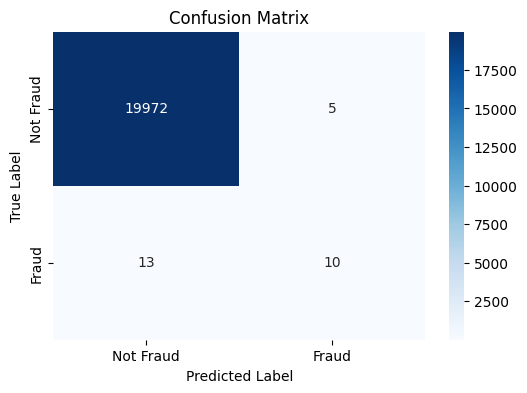

Random Forest Classifier Accuracy: [0.999125  0.999125  0.9990625 0.999125  0.9993125]
Cross Validation Recall scores are: [0.22222222 0.22222222 0.21052632 0.31578947 0.42105263]
Average Cross Validation Recall score: 0.2783625730994152
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     19977
       Fraud       0.67      0.43      0.53        23

    accuracy                           1.00     20000
   macro avg       0.83      0.72      0.76     20000
weighted avg       1.00      1.00      1.00     20000

isFraud
0.0    0.998838
1.0    0.001162
Name: proportion, dtype: float64


In [ ]:
#training with SMOTE

rf = RandomForestClassifier(n_estimators=1000, random_state=13)
rf.fit(X_train_resampled, y_train_resampled)

Y_pred = rf.predict(X_test)
#rf.score(X_train, y_train)

scoreAcc = cross_val_score(rf, X_train, y_train, cv=kf, scoring='accuracy')
scoreRe = cross_val_score(rf, X_train, y_train, cv=kf, scoring='recall')

cm = confusion_matrix(y_test, Y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Random Forest Classifier Accuracy: {}".format(scoreAcc))
print("Cross Validation Recall scores are: {}".format(scoreRe))
print("Average Cross Validation Recall score: {}".format(scoreRe.mean()))
print(classification_report(y_test, Y_pred, target_names=["Not Fraud", "Fraud"]))

In [ ]:
# Hyperparameter grid to optimize recall

rf = RandomForestClassifier(random_state=13)

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'class_weight': ['balanced', {0: 1, 1: 10}]
}

grid_search = GridSearchCV(rf, param_grid, scoring='recall', cv=5, verbose=2)
grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters
print("Best parameters found:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

scoreAcc = cross_val_score(rf, X_train, y_train, cv=kf, scoring='accuracy')
scoreRe = cross_val_score(rf, X_train, y_train, cv=kf, scoring='recall')

cm = confusion_matrix(y_test, Y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Random Forest Classifier Accuracy: {}".format(scoreAcc))
print("Cross Validation Recall scores are: {}".format(scoreRe))
print("Average Cross Validation Recall score: {}".format(scoreRe.mean()))
print(classification_report(y_test, Y_pred, target_names=["Not Fraud", "Fraud"]))

KeyboardInterrupt: 